In [2]:
import os
os.chdir("../")
os.getcwd()

'c:\\Users\\jprmg\\Desktop\\Plant_Disease'

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the CSV file
labels_df = pd.read_csv('artifacts/workData/df.csv')

# Combine the binary labels into a single class label
labels_df['class'] = labels_df[['healthy', 'multiple_diseases', 'rust', 'scab']].idxmax(axis=1)

# Update image paths to include ".jpg"
labels_df['image_id'] = labels_df['image_id'].apply(lambda x: f"{x}.jpg")

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=42, stratify=labels_df['class'])


In [4]:
train_df

,Unnamed: 0,image_id,healthy,multiple_diseases,rust,scab,class
278,278,img_278.jpg,1,0,0,0,healthy
1601,1601,img_1601.jpg,1,0,0,0,healthy
8,8,img_8.jpg,0,0,0,1,scab
1986,1986,img_1986.jpg,0,1,0,0,multiple_diseases
2241,2241,img_2241.jpg,0,1,0,0,multiple_diseases
...,...,...,...,...,...,...,...
389,389,img_389.jpg,1,0,0,0,healthy
948,948,img_948.jpg,1,0,0,0,healthy
352,352,img_352.jpg,0,0,0,1,scab
627,627,img_627.jpg,0,0,1,0,rust


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories
image_dir = 'artifacts\\preprocesamiento'  # Ensure this is the correct path

datagen = ImageDataGenerator(
    rotation_range=20,  # Rango de rotación en grados
    width_shift_range=0.1,  # Rango de traslación horizontal
    height_shift_range=0.1,  # Rango de traslación vertical
    zoom_range=0.1,  # Rango de zoom aleatorio
    horizontal_flip=True,  # Volteo horizontal aleatorio
    vertical_flip=False,  # Volteo vertical aleatorio
    brightness_range=[0.8, 1.2],  # Rango de cambio de brillo
    rescale=1./255  # Reescalado de píxeles
)

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='image_id',  # Column with image filenames
    y_col='class',     # Column with class labels
    target_size=(224, 224),  # Resize images
    batch_size=32,
    class_mode='categorical'  # Use 'categorical' for multi-class classification
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='image_id',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 1990 validated image filenames belonging to 4 classes.
Found 498 validated image filenames belonging to 4 classes.


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
earlyStopping=EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=10,)

model = Sequential([
    Conv2D(8, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    

    Dense(512, activation='relu',kernel_regularizer=l2(0.01)),
    Dropout(0.45 ),
    Dense(4, activation='softmax')  # 4 classes
])



model.compile(optimizer=Adam(learning_rate=0.001),  # Probar con una tasa de aprendizaje más baja
              loss='categorical_crossentropy',
              metrics=['accuracy'],)

In [9]:

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[earlyStopping]
)





Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 31s 421ms/step - accuracy: 0.2421 - loss: 3.5484 - val_accuracy: 0.2458 - val_loss: 1.6295
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3125 - loss: 1.6272 - val_accuracy: 0.3333 - val_loss: 1.6159
Epoch 3/100


c:\Users\jprmg\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 371ms/step - accuracy: 0.2440 - loss: 1.5126 - val_accuracy: 0.2562 - val_loss: 1.3887
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2500 - loss: 1.3899 - val_accuracy: 0.1667 - val_loss: 1.3901
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 391ms/step - accuracy: 0.2822 - loss: 1.3826 - val_accuracy: 0.2562 - val_loss: 1.3838
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1250 - loss: 1.3862 - val_accuracy: 0.2222 - val_loss: 1.3953
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 387ms/step - accuracy: 0.3022 - loss: 1.3690 - val_accuracy: 0.3292 - val_loss: 1.3660
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1875 - loss: 1.4519 - val_accuracy: 0.3333 - val_loss: 1.3155
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 389ms/step - accuracy: 0.3789 - loss: 1.3075 - val_accuracy: 0.4812 - val_loss: 1.1956
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5625 - loss: 1.1450 - val_accuracy: 0.3889 - 

In [10]:
val_loss, val_acc = model.evaluate(val_generator, verbose=2)
print(f'Validation accuracy: {val_acc}')
print(f"validacion loss:{val_loss}")


16/16 - 4s - 274ms/step - accuracy: 0.8333 - loss: 0.6359
Validation accuracy: 0.8333333134651184
validacion loss:0.6359236240386963


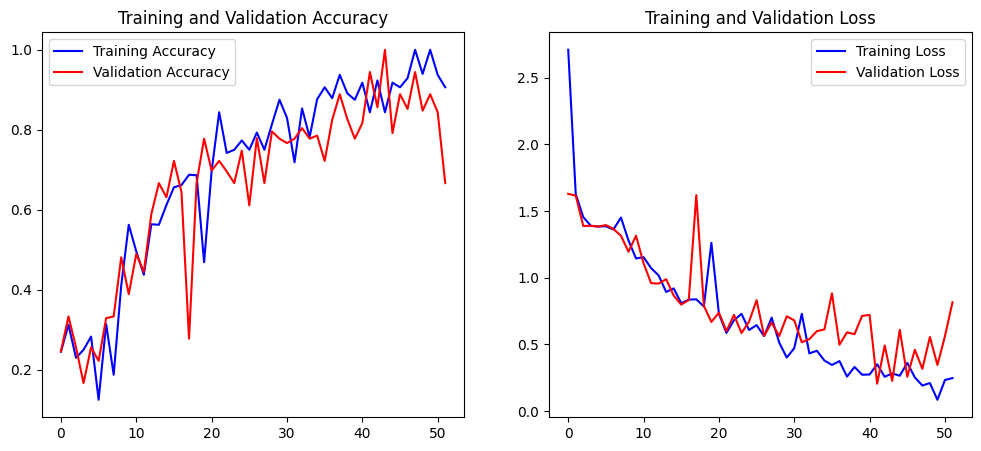

In [11]:
from matplotlib import pyplot as plt
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_history(history)